In [1]:
# from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from astropy.timeseries import LombScargle as lst

In [2]:
#somewhat arbitrarily used a few plotting colors
#set them to variables here so they can be easily changed
c1 = 'cornflowerblue'
c2 = 'navy'
c3 = 'rebeccapurple'
c4 = '#CF6275'
c5 = 'maroon'

In [3]:
def ps(name):
    '''save as postscript file'''
    plt.savefig(name+'.ps')
def png(name,dpi=200):
    '''save as png with sufficient quality'''
    plt.savefig(name+'.png',dpi=dpi,bbox_inches='tight')

# 1. Load in Data and Plot I Band Lightcurve

In [5]:
#load Ogle IV, only keep first three columns
og4 = np.loadtxt('phot1.dat',usecols=range(0,3))
#turn into panda dataframe with labelled columns based on known time units (Julian Date)
og4 = pd.DataFrame(og4,columns=['JD','I mag','I mag err'])
#add columns for MJD and MJD-50000, which will be the time unit used in all plots
og4['MJD'] = og4['JD']-2400000.5
og4['MJD-50000'] = og4['MJD']-50000
og4['I mag'] = og4['I mag']+.041 #calibrating
#deleting duplicates (points with same time)
og4 = og4.drop_duplicates(subset=['MJD'], keep='last')

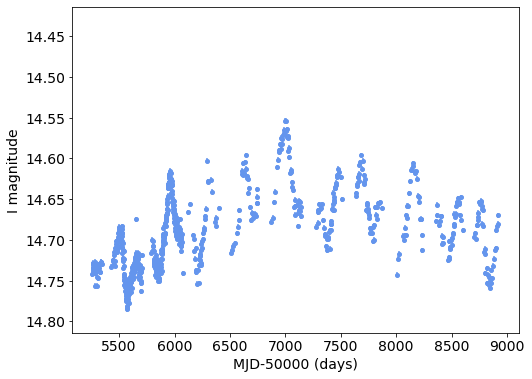

In [6]:
#Ogle IV
plt.figure(figsize=(8,6))
plt.errorbar(og4['MJD']-50000,og4['I mag'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.014,14.4+.014)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
#plt.savefig('Imag.ps') #testing saving plot as ps
# png('plot1')

# 2. Detrend Data and Perform LS Periodogram

In [7]:
#detrending by Georgios

# Detrend with window size, window size refers to number of points,
# so 100  points its about 100-200 days (OGLE takes 1 observation every 1-3 days)
# a more efficient way to detrend perhaps is to remove the average of each year, be carefull when detrending... 
# if you detrend using a window of 30 days .. and then you find a period of 30 days... 
# then you introduced an artificial signal.

Imag=og4['I mag']
window=201 #also tested other windows to make sure periodogram results unaffected
print('Smooth (window = ', window, ') and detrend data...')
Ismooth = signal.savgol_filter(Imag, window, 1)
Imean = np.mean(Imag)
print('Average I band magnitude', Imean)
og4['I detrend 2'] = Imag-Ismooth  + og4['I mag'].mean()

print('min:',og4['I detrend 2'].min(),'max:',og4['I detrend 2'].max())

# # clip large deviations
# mask = (Idetrend > -0.03) & (Idetrend < 0.03)
# Idetrend = Idetrend+Imean
# time = time[mask]
# Idetrend = Idetrend[mask]
# eIdetrend = Imag_err[mask]
# print 'No of selected data points:', len(time)


Smooth (window =  201 ) and detrend data...
Average I band magnitude 14.693077021822852
min: 14.590290952171104 max: 14.785156623812897


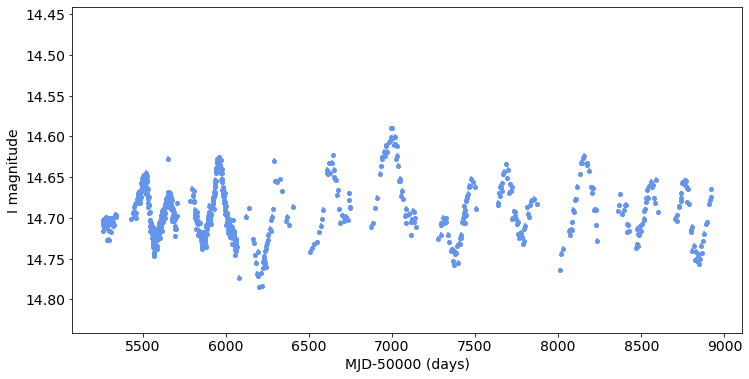

In [8]:
#detrended lightcurve
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.041,14.4+.041)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [9]:
#find link for credit
def periodogram(more=False,minf=.005,maxf=.05,t=og4['MJD-50000'],y=og4['I detrend 2'],dy=og4['I mag err'],bayes=False,sub=False):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(t, y)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
    if bayes: power = np.exp(power)
    plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    plt.xlabel('Period',fontsize=14)
    plt.ylabel('Power',fontsize=14)
    if more:
        return freq, power, 1/best_freq
    else:
        return 1/best_freq

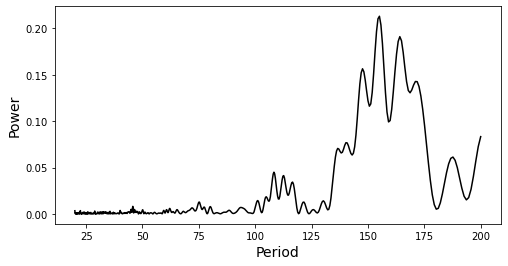

In [10]:
freq, power, best_p = periodogram(minf=.005,more=True)
#png('presgram')

In [11]:
pdframe = pd.DataFrame(columns=['freq','power','period'])
pdframe['freq'] = freq
pdframe['power'] = power
pdframe['period'] = 1./freq

In [12]:
pdframe = pdframe.sort_values(by='power',ascending=False)
pdframe[:5] #164 also high-powered

,freq,power,period
53,0.006448,0.212960,155.093654
54,0.006475,0.210207,154.439379
52,0.006420,0.203575,155.753495
55,0.006502,0.196313,153.790602
40,0.006093,0.190985,164.133090


In [13]:
best_p

155.09365367860207

In [14]:
mask = og4['MJD-50000'] < 6500
masked_og4 = og4[mask]

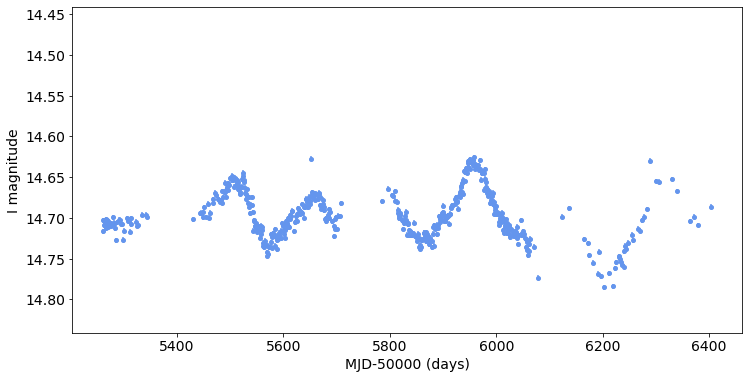

In [15]:
#detrended lightcurve
plt.figure(figsize=(12,6))
plt.errorbar(masked_og4['MJD-50000'],masked_og4['I detrend 2'],yerr=masked_og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.041,14.4+.041)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [16]:
#find link for credit
def periodogram_mask(more=False,minf=.005,maxf=.05,t=masked_og4['MJD-50000'],y=masked_og4['I detrend 2'],dy=masked_og4['I mag err'],bayes=False,sub=False):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(t, y)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
    if bayes: power = np.exp(power)
    plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    plt.xlabel('Period',fontsize=14)
    plt.ylabel('Power',fontsize=14)
    if more:
        return freq, power, 1/best_freq
    else:
        return 1/best_freq

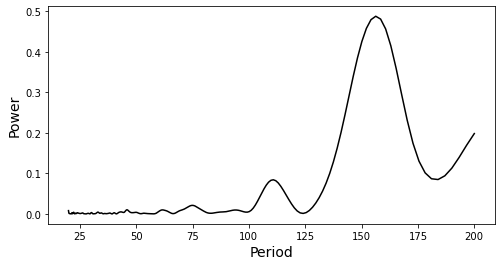

In [17]:
freq, power, best_p = periodogram_mask(minf=.005,more=True)
#png('presgram')